import sklearn
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [12]:
from preamble import *
import sklearn
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.decomposition import PCA

#### 고유얼굴 특성 추출

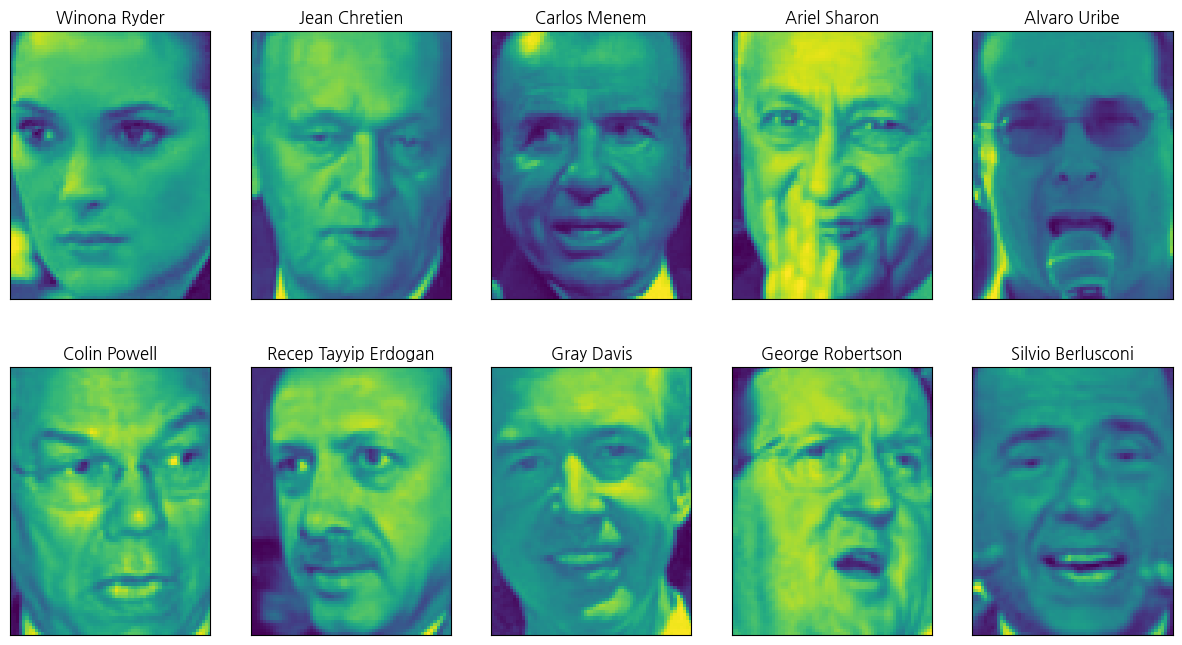

In [2]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)  # 한사람당 이미지 20장
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),                 # 2*5 10 장
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [3]:
people.target[0:10], people.target_names[people.target[0:10]]
# target 번호와 인물 맞추기

(array([61, 25,  9,  5,  1, 10, 48, 17, 13, 54], dtype=int64),
 array(['Winona Ryder', 'Jean Chretien', 'Carlos Menem', 'Ariel Sharon',
        'Alvaro Uribe', 'Colin Powell', 'Recep Tayyip Erdogan',
        'Gray Davis', 'George Robertson', 'Silvio Berlusconi'],
       dtype='<U25'))

In [4]:
print("people.images.shape:", people.images.shape)
print("클래스 개수:", len(people.target_names))

people.images.shape: (3023, 87, 65)
클래스 개수: 62


In [5]:
# 각 타깃이 나타난 횟수 계산
counts = np.bincount(people.target)
# 타깃별 이름과 횟수 출력
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [6]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1     # mask로 비교하며 인물이 일치할 시 1로 처리

X_people = people.data[mask]
y_people = people.target[mask]

# 0~255 사이의 흑백 이미지의 픽셀 값을 0~1 사이로 스케일 조정합니다.
# (옮긴이) MinMaxScaler를 적용하는 것과 거의 동일합니다.
X_people = X_people / 255.                                  # 255*255 / 255: 0~1로 스케일링

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# 데이터를 훈련 세트와 테스트 세트로 나눕니다
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
# 이웃 개수를 한 개로 하여 KNeighborsClassifier 모델을 만듭니다
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("1-최근접 이웃의 테스트 세트 점수: {:.2f}".format(knn.score(X_test, y_test)))
# 애매한 점수 

1-최근접 이웃의 테스트 세트 점수: 0.22


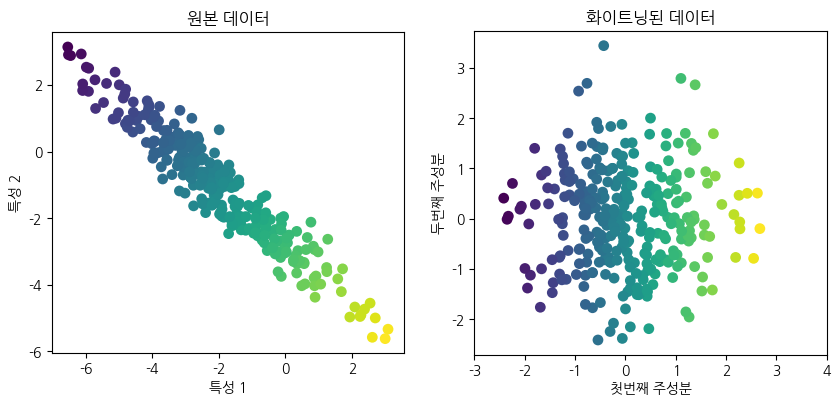

In [14]:
# 위의 방법으로는 각픽셀 위치에 일치하는 픽셀을 비교 : 이 방법으로느 얼굴 특징 잡기 힘듬
# 따라서 화이트닝으로 주성분의 스케일을 일치하게 함
mglearn.plots.plot_pca_whitening()

In [15]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape:", X_train_pca.shape)

X_train_pca.shape: (1547, 100)


In [16]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("테스트 세트 정확도: {:.2f}".format(knn.score(X_test_pca, y_test)))

테스트 세트 정확도: 0.30


In [17]:
print("pca.components_.shape:", pca.components_.shape)

pca.components_.shape: (100, 5655)


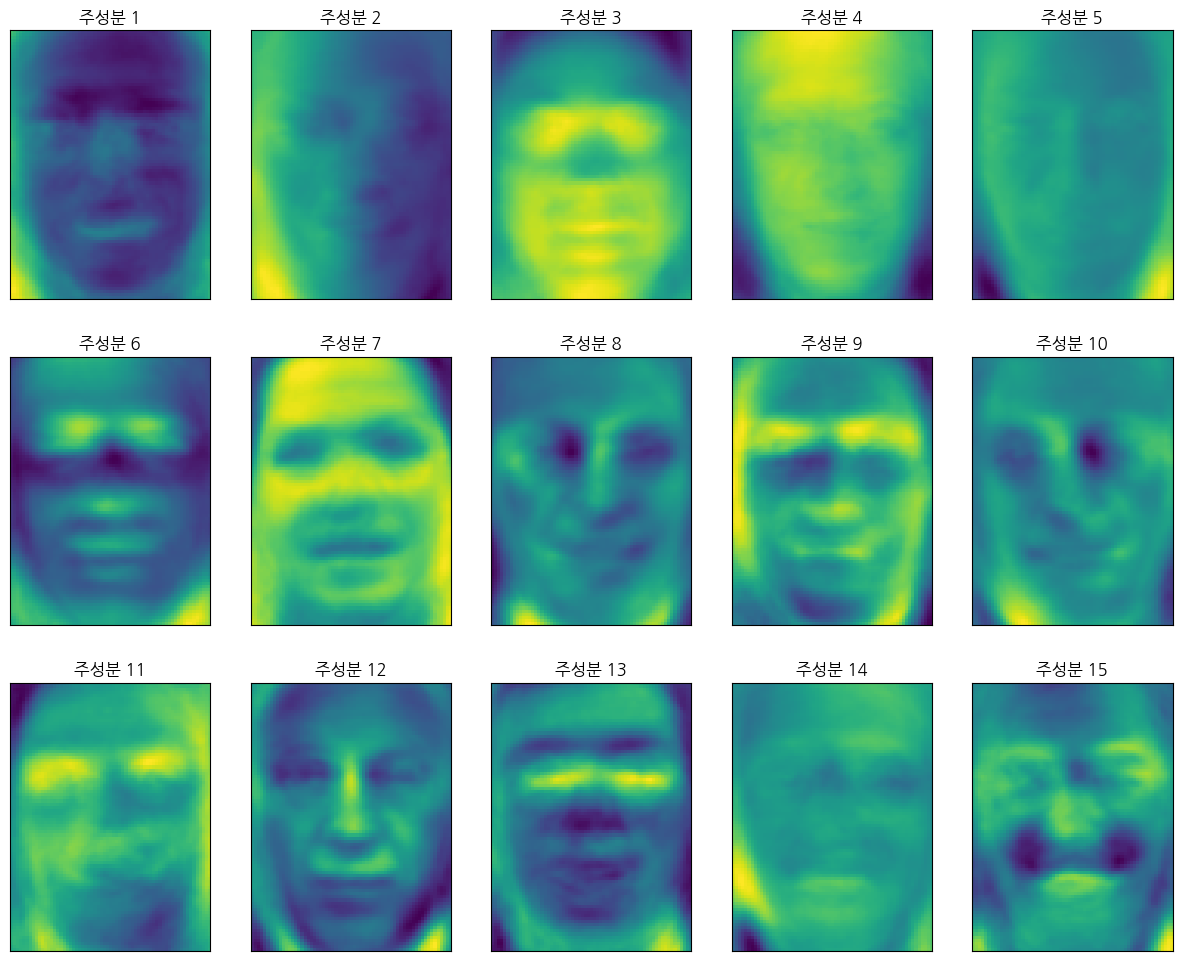

In [18]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("주성분 {}".format((i + 1)))

눈 인식 <br>
된다는 가정하에 매우 빠른 처리

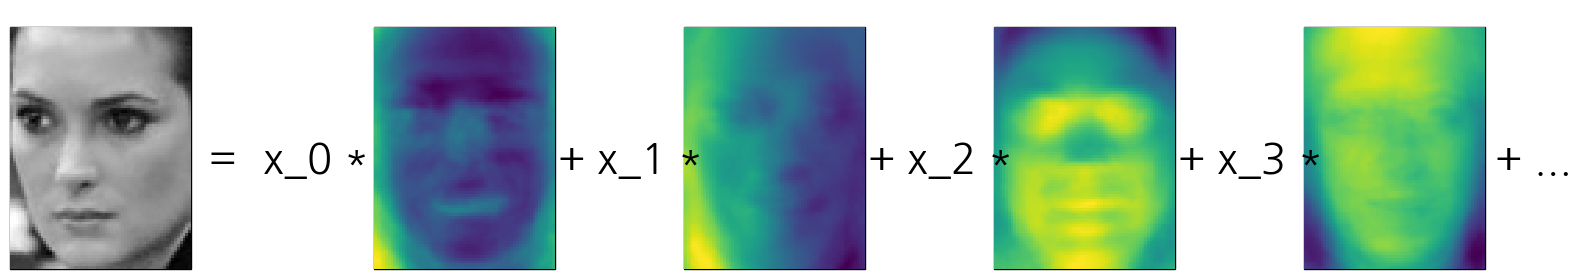

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

image_shape = people.images[0].shape
plt.figure(figsize=(20, 3))
ax = plt.gca()

imagebox = OffsetImage(people.images[0], zoom=2, cmap="gray")
ab = AnnotationBbox(imagebox, (.05, 0.4), pad=0.0, xycoords='data')
ax.add_artist(ab)

for i in range(4):
    imagebox = OffsetImage(pca.components_[i].reshape(image_shape), zoom=2,
                           cmap="viridis")

    ab = AnnotationBbox(imagebox, (.285 + .2 * i, 0.4),
                        pad=0.0, xycoords='data')
    ax.add_artist(ab)
    if i == 0:
        plt.text(.155, .3, 'x_{} *'.format(i), fontdict={'fontsize': 30})
    else:
        plt.text(.145 + .2 * i, .3, '+ x_{} *'.format(i),
                 fontdict={'fontsize': 30})

plt.text(.95, .3, '+ ...', fontdict={'fontsize': 30})

plt.rc('text')
plt.text(.12, .3, '=', fontdict={'fontsize': 30})
plt.axis("off")
plt.show()
plt.close()
plt.rc('text')

________________________________________________________________________________
[Memory] Calling mglearn.plot_pca.pca_faces...
pca_faces(array([[0.001927, ..., 0.00083 ],
       ...,
       [0.000144, ..., 0.001989]], dtype=float32), 
array([[0.000923, ..., 0.000964],
       ...,
       [0.001569, ..., 0.001   ]], dtype=float32))
________________________________________________________pca_faces - 0.8s, 0.0min


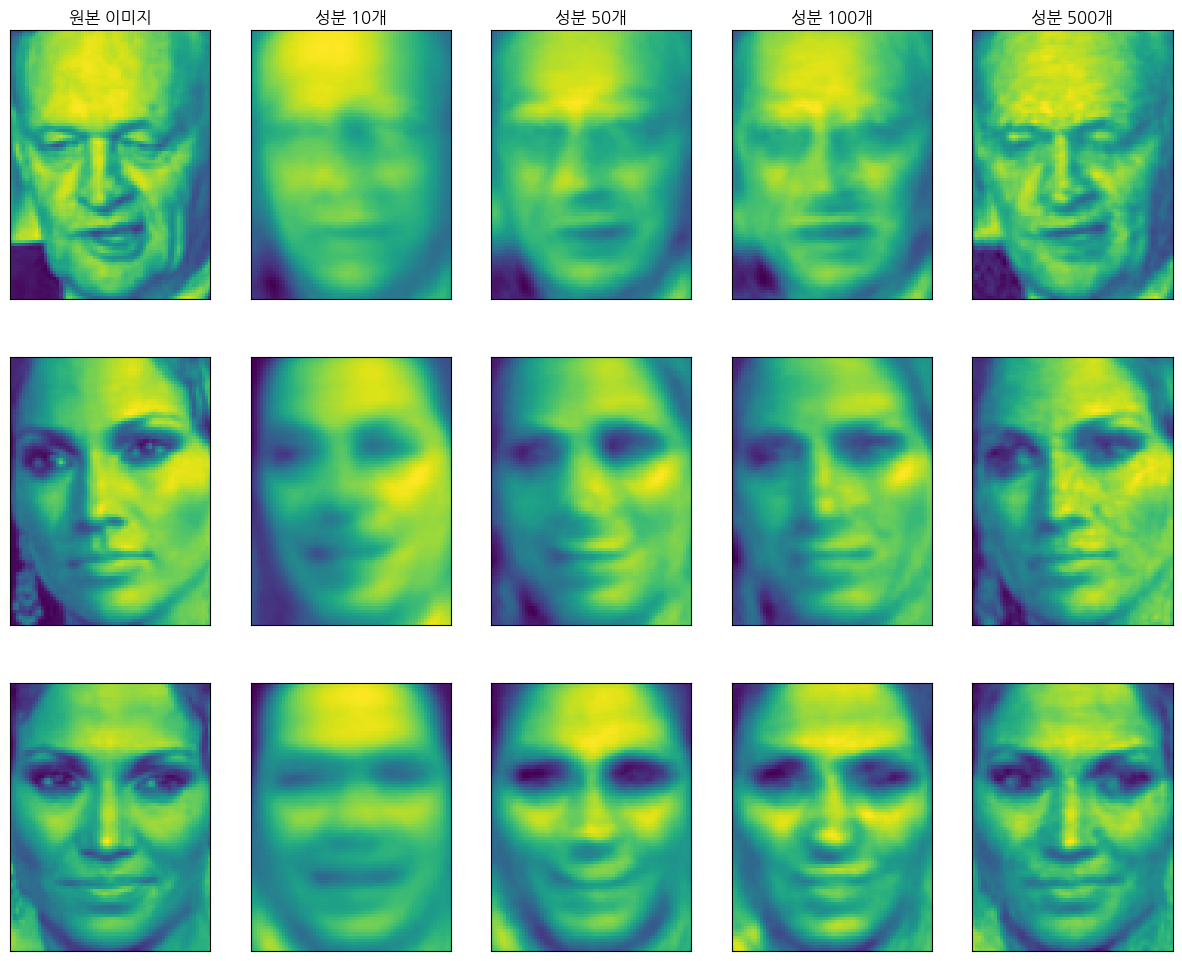

In [20]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

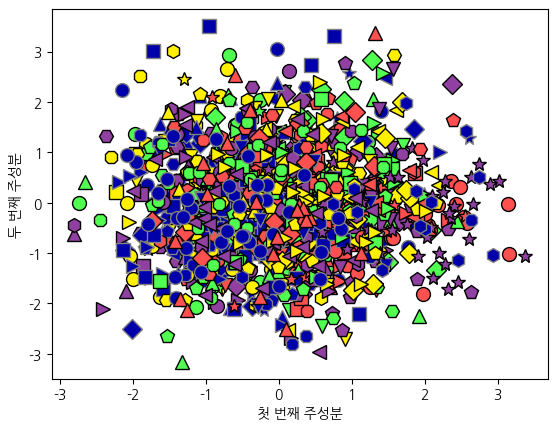

In [21]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("첫 번째 주성분")
plt.ylabel("두 번째 주성분")
plt.show() # 책에는 없음

#### 설명된 분산의 비율

In [22]:
np.sum(pca.explained_variance_ratio_)

0.8979816

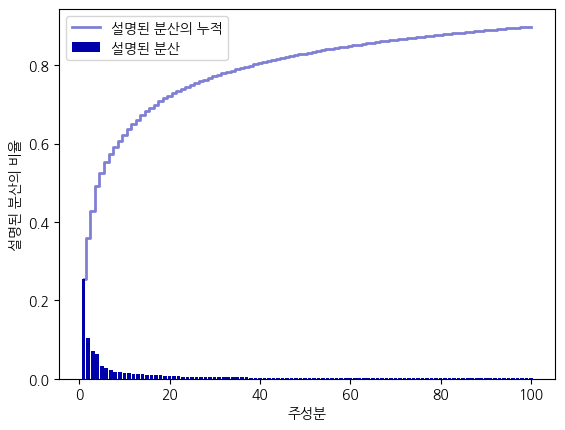

In [23]:
plt.bar(range(1,101), pca.explained_variance_ratio_,
        align='center', label='설명된 분산')
plt.step(range(1,101), np.cumsum(pca.explained_variance_ratio_), alpha=0.5,
         where='mid', label='설명된 분산의 누적')
plt.ylabel('설명된 분산의 비율')
plt.xlabel('주성분')
plt.legend()
plt.show()

In [24]:
pca = PCA(n_components=40, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

knn.fit(X_train_pca, y_train)
print("테스트 세트 정확도: {:.2f}".format(knn.score(X_test_pca, y_test)))

테스트 세트 정확도: 0.30


In [25]:
pca = PCA(n_components=0.8, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

knn.fit(X_train_pca, y_train)
print("테스트 세트 정확도: {:.2f}".format(knn.score(X_test_pca, y_test)))
print("주성분 개수: ", pca.n_components_)

테스트 세트 정확도: 0.29
주성분 개수:  39


ML: 0.47... 맞지않음 <br>
DL: (비정형)CNN 정확도: 1

### 3.4.3 t-SNE를 이용한 매니폴드 학습

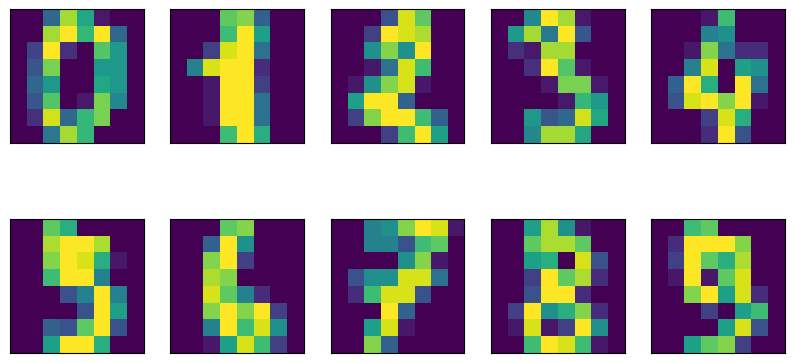

In [27]:
from sklearn.datasets import load_digits
digits = load_digits()

fig,axes = plt.subplots(2,5,figsize=(10,5),subplot_kw={'xticks':(),'yticks':()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

In [28]:
##pca 생략

NameError: name 'colors' is not defined

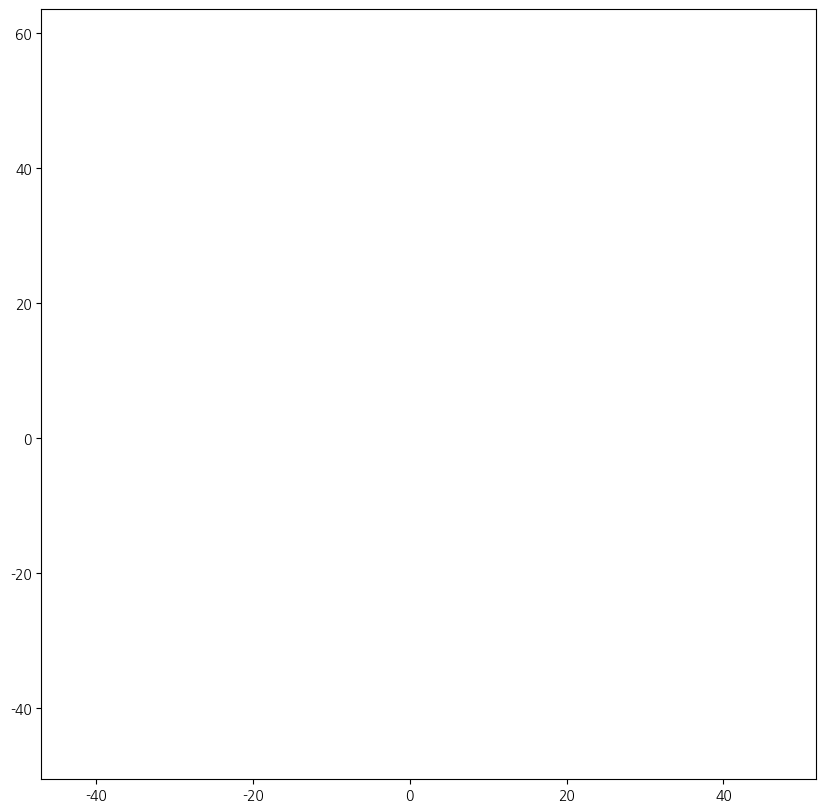

In [30]:
##t-SNE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10,10))
plt.xlim(digits_tsne[:,0].min(), digits_tsne[:,0].max() +1)
plt.ylim(digits_tsne[:,1].min(), digits_tsne[:,1].max() +1)

for i in range(len(digits.data)):
    #x,y 좌표를 tsne에서 가져온다
    plt.text(digits_tsne[i,0],digits_tsne[i,1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight':'bold','size':9})

plt.xlabel("t-SNE 특성 0")
plt.ylabel("t-SNE 특성 1")

Text(0, 0.5, 'Feature 1')

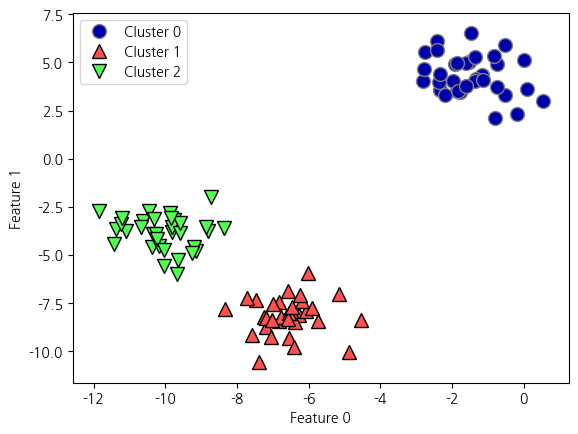

In [31]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering

X,y = make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:,0],X[:,1],assignment)
plt.legend(["Cluster 0","Cluster 1","Cluster 2"],loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

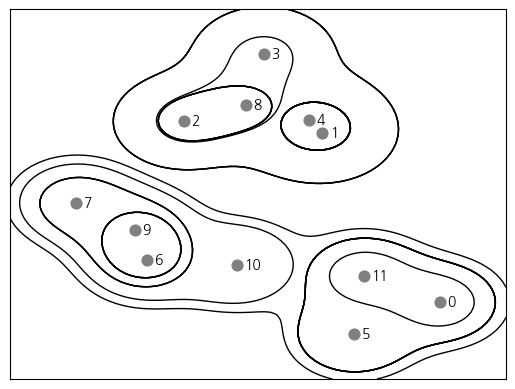

In [32]:
mglearn.plots.plot_agglomerative()

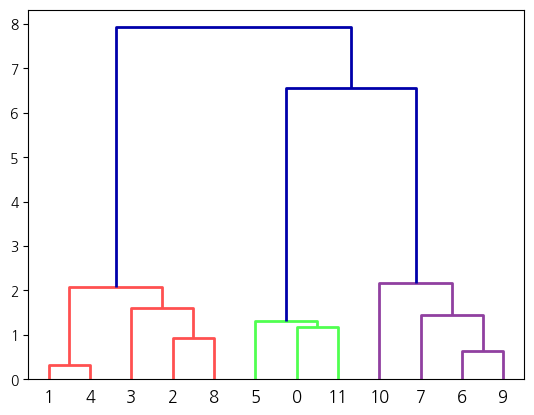

In [35]:
from scipy.cluster.hierarchy import dendrogram, ward # 생물학에서 사용
X,y = make_blobs(random_state=0, n_samples=12)
linkage_array = ward(X)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound

### 3.5.3 DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
X,y = make_blobs(random_state=0,n_samples=12)

dbscan = DBSCAN()
cl